In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"13xmiSh8AgQjj6BJ7Dxu_byo59bnlUT8h"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
# Required Libraries
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
from numpy import linalg
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics

%matplotlib inline

In [0]:
dataset = pd.read_csv('data.csv',encoding="ISO-8859-1") # dataset incorporation
dataset.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [0]:
dataset.drop(['stn_code','agency','sampling_date','location_monitoring_station'], axis=1,inplace=True)
#dataset.info()
#dataset.head()

In [0]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    #return df_out

remove_outlier(dataset,'so2')
remove_outlier(dataset,'no2')
remove_outlier(dataset,'rspm')
remove_outlier(dataset,'spm')


In [0]:
by_State=dataset.groupby('state')

def impute_mean(series):
    return series.fillna(series.mean())

dataset['rspm'] = by_State['rspm'].transform(impute_mean)
dataset['so2'] = by_State['so2'].transform(impute_mean)
dataset['no2'] = by_State['no2'].transform(impute_mean)
dataset['spm'] = by_State['spm'].transform(impute_mean)
dataset['pm2_5'] = by_State['pm2_5'].transform(impute_mean)


In [0]:
# Missing values being filled in columns
for col in dataset.columns.values:
    if dataset[col].isnull().sum() == 0:
        continue
    if col == 'date':
        guess_values = dataset.groupby('state')['date'].apply(lambda x: x.mode().max())
    elif col=='type':
        guess_values = dataset.groupby('state')['type'].apply(lambda x: x.mode().max())
    else:
        guess_values = dataset.groupby('state')['location'].apply(lambda x: x.mode().max())
dataset.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,NaN,1990-03-01


In [0]:
# Derivation for Individual Pollutant Index and AQI STARTS HERE

# EPA METHOD FORMULA
#  AQI_{P} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SO2 pollutant by EPA method formula given above
#  SO2 is scaled between 0-1600
def calculate_si(so2):
    si=0
    if (so2<=40):
     si = so2 * (50/40)
    elif (so2>40 and so2<=80):
     si = 50 + (so2-40) * (50/(80-40))
    elif (so2>80 and so2<=380):
     si = 100 + (so2-80) * (100/(380-80))
    elif (so2>380 and so2<=800):
     si = 200 + (so2-380) * (100/(800-380))
    elif (so2>800 and so2<=1600):
     si = 300 + (so2-800) * (100/(1600-800))
    elif (so2>1600):
     si = 400 + (so2-1600) * (100/800)
    return si

# calling the function to calulate so2 pollutant index
dataset['si'] = dataset['so2'].apply(calculate_si)
df_si = dataset[['so2','si']]
df_si.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [0]:
#Function to calculate no2 individual pollutant index(ni)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of NO2 pollutant by EPA method formula given above
#  NO2 is scaled between 0-400
def calculate_ni(no2):
    ni = 0
    if(no2<=40):
     ni = no2*50/40
    elif(no2>40 and no2<=80):
     ni = 50 + (no2-40)*(50/(80-40))
    elif(no2>80 and no2<=180):
     ni = 100 + (no2-80)*(100/(180-80))
    elif(no2>180 and no2<=280):
     ni = 200 + (no2-180)*(100/(280-180))
    elif(no2>280 and no2<=400):
     ni = 300 + (no2-280)*(100/(400-280))
    else:
     ni = 400 + (no2-400)*(100/120)
    return ni

# calling the function to calulate so2 pollutant index
dataset['ni'] = dataset['no2'].apply(calculate_ni)
df_ni = dataset[['no2','ni']]
df_ni.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [0]:
#Function to calculate rspm individual pollutant index(rpi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of RSPM pollutant by EPA method formula given above
#  RSPM is scaled between 0-400
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi = rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi = 50+(rpi-30)*50/(60-30)
    elif(rpi>60 and rpi<=90):
     rpi = 100+(rpi-60)*100/(90-60)
    elif(rpi>90 and rpi<=120):
     rpi = 200+(rpi-90)*100/(120-90)
    elif(rpi>120 and rpi<=250):
     rpi = 300+(rpi-120)*(100/(250-120))
    else:
     rpi = 400+(rpi-250)*(100/130)
    return rpi

# calling the function to calulate RSPM pollutant index
dataset['rpi']=dataset['rspm'].apply(calculate_si)
df_rpi = dataset[['rspm','rpi']]
df_rpi.head()


,rspm,rpi
0,78.182824,97.72853
1,78.182824,97.72853
2,78.182824,97.72853
3,78.182824,97.72853
4,78.182824,97.72853


In [0]:
#Function to calculate spm individual pollutant index(spi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SPM pollutant by EPA method formula given above
#  SPM is scaled between 0-400
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi = spm*50/50
    elif(spm>50 and spm<=100):
     spi = 50 + (spm-50)*(50/(100-50))
    elif(spm>100 and spm<=250):
     spi = 100 + (spm-100)*(100/(250-100))
    elif(spm>250 and spm<=350):
     spi=200 + (spm-250)*(100/(350-250))
    elif(spm>350 and spm<=430):
     spi=300 + (spm-350)*(100/(430-350))
    else:
     spi=400+(spm-430)*(100/430)
    return spi

# calling the function to calulate SPM pollutant index
dataset['spi'] = dataset['spm'].apply(calculate_spi)
df_spm = dataset[['spm','spi']]
df_spm.head()

,spm,spi
0,200.260378,166.840252
1,200.260378,166.840252
2,200.260378,166.840252
3,200.260378,166.840252
4,200.260378,166.840252


In [0]:
#function to calculate the air quality index (AQI) of every data value its is calculated as per indian govt standards

# AQI = MAX ( AQI_{SO2}, AQI_{NO2}, AQI_{RSPM}, AQI_{SPM})
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi

# calling the function to calulate AQI 
dataset['AQI'] = dataset.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df= dataset[['state','si','ni','rpi','spi','AQI']]
df.head()

,state,si,ni,rpi,spi,AQI
0,Andhra Pradesh,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,5.875,9.375,97.72853,166.840252,166.840252


In [0]:
dataset.fillna(0.0, inplace=True)

In [0]:
def AQI_Range(x):
    if x<=50:
        return "Good"
    elif x>50 and x<=100:
        return "Moderate"
    elif x>100 and x<=200:
        return "Unhealthy for sensitive groups"
    elif x>200 and x<=300:
        return "Unhealthy"
    elif x>300 and x<=400:
        return "Very unhealthy"
    elif x>400:
        return "Hazardous"

dataset['AQI_Range'] = dataset['AQI'] .apply(AQI_Range)
dataset.head()


,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,AQI,AQI_Range
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,166.840252,Unhealthy for sensitive groups
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups


In [0]:
dataset['AQI_label'] = dataset['AQI_Range'].astype('category')
cat_columns = dataset.select_dtypes(['category']).columns
dataset[cat_columns] = dataset[cat_columns].apply(lambda x: x.cat.codes)

dataset.head()


,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,AQI,AQI_Range,AQI_label
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4


In [0]:
def AQI_Range_Binary_Label(x):
    if x<=200:
        return 0
    elif x>200:
        return 1
    
dataset['AQI_Range_Binary'] = dataset['AQI'] .apply(AQI_Range_Binary_Label)
dataset.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,AQI,AQI_Range,AQI_label,AQI_Range_Binary
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0


In [0]:
dataset['date'] = pd.to_datetime(dataset['date'],format='%Y-%m-%d') # date parse
dataset['year'] = dataset['date'].dt.year # year
dataset['year'] = dataset['year'].fillna(0.0).astype(int)
dataset = dataset[(dataset['year']>0)]

In [0]:
dataset['state_label'] = dataset['state'].astype('category')
cat_columns = dataset.select_dtypes(['category']).columns
dataset[cat_columns] = dataset[cat_columns].apply(lambda x: x.cat.codes)
dataset.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,AQI,AQI_Range,AQI_label,AQI_Range_Binary,year,state_label
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0


In [0]:
dataset["type_label"]=dataset["type"].astype(str)
dataset["type_label"] = np.where(dataset["type"].str.contains('Residential, Rural and other Areas'), 1, 0)

dataset.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,AQI,AQI_Range,AQI_label,AQI_Range_Binary,year,state_label,type_label
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0,1
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0,0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0,1
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0,1
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,166.840252,Unhealthy for sensitive groups,4,0,1990,0,0


Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'AQI'], dtype='object')


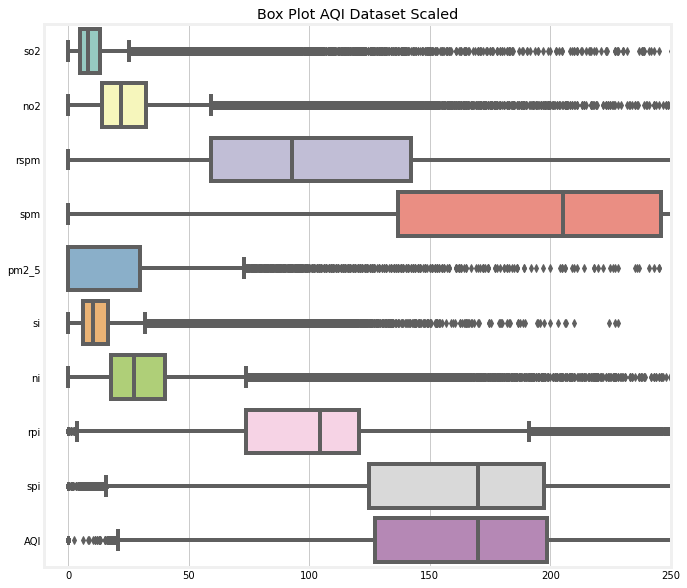

In [0]:
dataset_box=dataset.drop(['state', 'location', 'date','state_label','type_label','type','AQI_label','AQI_Range_Binary','year','AQI_Range'],axis=1)
f, ax = plt.subplots(figsize=(10, 10))

print(dataset_box.columns)
ax.set_facecolor('#FFFFFF')
plt.title("Box Plot AQI Dataset Scaled")
ax.set(xlim=(-10, 250))
ax = sns.boxplot(data = dataset_box, 
  orient = 'h', 
  palette = 'Set3')

In [0]:
predictor_names=dataset_box.columns.values
predictor_names=predictor_names.tolist()
predictor_names.pop()
predictor_names


['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi']

In [0]:
def rank_predictors(dat,l,f='AQI_Range_Binary'):
    rank={}
    max_vals=dat.max()
    median_vals=dat.groupby(f).median()  # We are using the median 
    for p in l:
        score=np.abs((median_vals[p][1]-median_vals[p][0])/max_vals[p])
        rank[p]=score
    return rank
cat_rank=rank_predictors(dataset,predictor_names) 
cat_rank

{'ni': 0.017259414225941423,
 'no2': 0.012557077625570776,
 'pm2_5': 0.0,
 'rpi': 0.030184097703318313,
 'rspm': 0.013318464572002605,
 'si': 0.007971303308090873,
 'so2': 0.0022002200220021992,
 'spi': 0.16236259814418275,
 'spm': 0.05828402366863905}

In [0]:
# Take the top predictors based on mean difference
cat_rank=sorted(cat_rank.items(), key=lambda x: x[1],reverse= True)

ranked_predictors=[]
for f in cat_rank:
    ranked_predictors.append(f[0])
ranked_predictors



['spi', 'spm', 'rpi', 'ni', 'rspm', 'no2', 'si', 'so2', 'pm2_5']

In [0]:
data_log=dataset.drop(['state','type','date','location'],axis=1)


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings; warnings.simplefilter('ignore')

In [0]:
def logistic_regression(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    sc = StandardScaler()
    
    # Feature scaling
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    #Fitting logistic regression to the training set
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(x_train,y_train)
    
    
    # Logistic regression cross validation
    #Kfold = KFold(len(ranked_predictors), shuffle=False)
    #print("KfoldCrossVal mean score using Logistic regression is %s \n" %cross_val_score(classifier,x,y,cv=10).mean())
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    cvs=cross_val_score(classifier, x_train, y_train, cv=k_fold).mean()
    print("KfoldCrossVal mean score using Logistic regression is %s \n"%cvs)
    
    print("Logistic Analysis Report")
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test,y_pred))

    print('-----------------------------------------------------------------')
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred, average='micro'))
    print("precision score: ", precision_score(y_test,y_pred, average='micro'))
    print("f1 score: ", f1_score(y_test,y_pred,average='micro'))
    accuracy = accuracy_score(y_test,y_pred)
    print("accuracy score: ", accuracy)
    print('-----------------------------------------------------------------')


    print(y_pred)
    #Accuracy score
    print ("Accuracy Score:%.2f" % metrics.accuracy_score(y_test,classifier.predict(x_test)))
    #probabilty of dependent variable
    y_pred_proba = classifier.predict_proba(x_test)[::,1]
    print('Probabilty of dependent variable')
    print(y_pred_proba.mean())
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    return accuracy

In [0]:
def logit_summary(y,X):
    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print("Model Summary")
    print(result.summary2())

Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'AQI',
       'AQI_Range', 'AQI_label', 'AQI_Range_Binary', 'year', 'state_label',
       'type_label'],
      dtype='object')
KfoldCrossVal mean score using Logistic regression is 0.994626783546914 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     81908
           1       1.00      0.98      0.99     27028

    accuracy                           0.99    108936
   macro avg       1.00      0.99      0.99    108936
weighted avg       0.99      0.99      0.99    108936

-----------------------------------------------------------------
test-set confusion matrix:
 [[81836    72]
 [  567 26461]]
recall score:  0.9941341705221415
precision score:  0.9941341705221415
f1 score:  0.9941341705221415
accuracy score:  0.9941341705221415
-----------------------------------------------------------------
[0 0 0 ... 0 0 1]
Accuracy Score:0.99
Probabilty

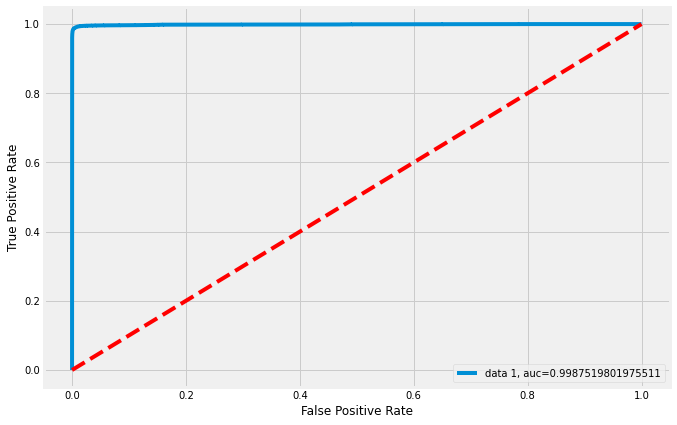

Optimization terminated successfully.
         Current function value: 0.022539
         Iterations 13
Model Summary
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.960      
Dependent Variable: AQI_Range_Binary AIC:              19666.6171 
Date:               2020-04-10 13:49 BIC:              19798.4348 
No. Observations:   435742           Log-Likelihood:   -9821.3    
Df Model:           11               LL-Null:          -2.4395e+05
Df Residuals:       435730           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     13.0000                                       
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
so2            0.0149    0.0024    6.0866  0.0000   0.0101   0.0197
no2            0.3865    0.0140   

In [0]:
data_log_1=dataset.drop(['state','type','date','location','AQI_label','AQI_Range','AQI','AQI_Range_Binary'],axis=1)
x=data_log_1.iloc[:,:]
print(data_log.columns)
y=data_log.iloc[:,12]

accuracy_lr1 = logistic_regression(x,y)
logit_summary(y,x)

In [0]:
# dont include
#Logistic Regression Model 2
data_log_2=dataset.drop(['state','type','date','location','AQI_Range','type_label','AQI_label','AQI'],axis=1)


In [0]:
#dont include
x=data_log_2.iloc[:,:]
y=dataset['type_label']
accuracy_lr2 = logistic_regression(x,y)
logit_summary(y,x)

In [0]:
# dont include
print(data_log.columns)

In [0]:
# dont include
x=dataset[predictor_names]

y=data_log.iloc[:,15]
accuracy_lr3 = logistic_regression(x,y)
logit_summary(y,x)

In [0]:
from sklearn.naive_bayes import GaussianNB
def Naive_Bayes(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    sc = StandardScaler()
    
    # Feature scaling
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    #Fitting logistic regression to the training set
    classifier = GaussianNB()
    classifier.fit(x_train,y_train)
    
    # Naive bayes cross validation
    #Kfold = KFold(len(ranked_predictors), shuffle=False)
    #print("KfoldCrossVal mean score using Logistic regression is %s \n" %cross_val_score(classifier,x,y,cv=10).mean())
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    cvs=cross_val_score(classifier, x_train, y_train, cv=k_fold).mean()
    print("KfoldCrossVal mean score using Logistic regression is %s \n"%cvs)
    
    print("Logistic Analysis Report")
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test,y_pred))

    print('-----------------------------------------------------------------')
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred, average='micro'))
    print("precision score: ", precision_score(y_test,y_pred, average='micro'))
    print("f1 score: ", f1_score(y_test,y_pred,average='micro'))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print('-----------------------------------------------------------------')


    print(y_pred)
    #Accuracy score
    print ("Accuracy Score:%.2f" % metrics.accuracy_score(y_test,classifier.predict(x_test)))
    # Probabilty of dependent variable
    y_pred_proba = classifier.predict_proba(x_test)[::,1]
    print('Probabilty of dependent variable')
    print(y_pred_proba.mean())
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return accuracy_score(y_test,y_pred)
  

Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'AQI',
       'AQI_Range', 'AQI_label', 'AQI_Range_Binary', 'year', 'state_label',
       'type_label'],
      dtype='object')
KfoldCrossVal mean score using Logistic regression is 0.9213998546724641 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     81908
           1       0.82      0.88      0.85     27028

    accuracy                           0.92    108936
   macro avg       0.89      0.91      0.90    108936
weighted avg       0.93      0.92      0.92    108936

-----------------------------------------------------------------
test-set confusion matrix:
 [[76601  5307]
 [ 3123 23905]]
recall score:  0.9226151134611148
precision score:  0.9226151134611148
f1 score:  0.9226151134611148
accuracy score:  0.9226151134611148
-----------------------------------------------------------------
[0 0 0 ... 0 0 0]
Accuracy Score:0.92
Probabilt

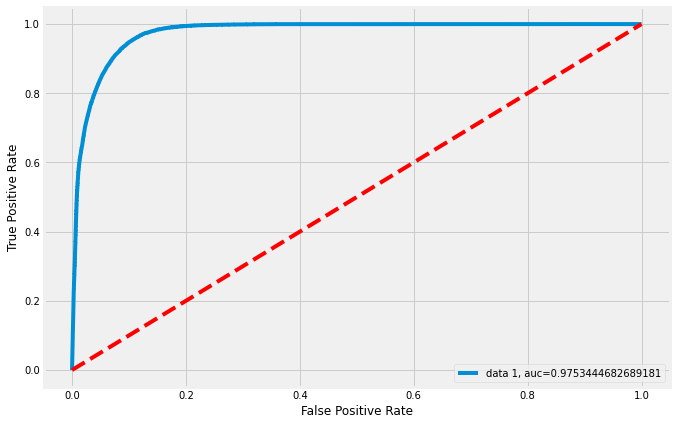

Optimization terminated successfully.
         Current function value: 0.022539
         Iterations 13
Model Summary
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.960      
Dependent Variable: AQI_Range_Binary AIC:              19666.6171 
Date:               2020-04-10 13:50 BIC:              19798.4348 
No. Observations:   435742           Log-Likelihood:   -9821.3    
Df Model:           11               LL-Null:          -2.4395e+05
Df Residuals:       435730           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     13.0000                                       
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
so2            0.0149    0.0024    6.0866  0.0000   0.0101   0.0197
no2            0.3865    0.0140   

In [0]:
data_log_1=dataset.drop(['state','type','date','location','AQI_label','AQI_Range','AQI','AQI_Range_Binary'],axis=1)
x=data_log_1.iloc[:,:]
print(data_log.columns)
y=data_log.iloc[:,12]
accuracy_nb1 = Naive_Bayes(x,y)
logit_summary(y,x)

In [0]:
from sklearn.svm import SVC 
def SVM_analysis(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    sc = StandardScaler()
    
    # Feature scaling
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    #Fitting logistic regression to the training set
    classifier = SVC(kernel='linear', random_state=1)
    classifier.fit(x_train,y_train)
    
    # Naive bayes cross validation
    #Kfold = KFold(len(ranked_predictors), shuffle=False)
    #print("KfoldCrossVal mean score using Logistic regression is %s \n" %cross_val_score(classifier,x,y,cv=10).mean())
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    cvs=cross_val_score(classifier, x_train, y_train, cv=k_fold).mean()
    print("KfoldCrossVal mean score using Logistic regression is %s \n"%cvs)
    
    print("Logistic Analysis Report")
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test,y_pred))

    print('-----------------------------------------------------------------')
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred, average='micro'))
    print("precision score: ", precision_score(y_test,y_pred, average='micro'))
    print("f1 score: ", f1_score(y_test,y_pred,average='micro'))
    accuracy = accuracy_score(y_test,y_pred)
    print("accuracy score: ", accuracy)
    print('-----------------------------------------------------------------')

    print(y_pred)
    #Accuracy score
    print ("Accuracy Score:%.2f" % metrics.accuracy_score(y_test,classifier.predict(x_test)))
    # Probabilty of dependent variable
    #y_pred_proba = classifier.predict_proba(x_test)[::,1]
    #print('Probabilty of dependent variable')
    #print(y_pred_proba.mean())

    return accuracy

In [0]:
data_log_1=dataset.drop(['state','type','date','location','AQI_label','AQI_Range','AQI','AQI_Range_Binary'],axis=1)
x=data_log_1.iloc[:,:]
print(data_log.columns)
y=data_log.iloc[:,12]
accuracy_svm = SVM_analysis(x,y)
logit_summary(y,x)

Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'AQI',
       'AQI_Range', 'AQI_label', 'AQI_Range_Binary', 'year', 'state_label',
       'type_label'],
      dtype='object')
KfoldCrossVal mean score using Logistic regression is 0.9958476926187222 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     81908
           1       1.00      0.98      0.99     27028

    accuracy                           1.00    108936
   macro avg       1.00      0.99      0.99    108936
weighted avg       1.00      1.00      1.00    108936

-----------------------------------------------------------------
test-set confusion matrix:
 [[81897    11]
 [  475 26553]]
recall score:  0.9955386649041639
precision score:  0.9955386649041639
f1 score:  0.9955386649041639
accuracy score:  0.9955386649041639
-----------------------------------------------------------------
[0 0 0 ... 0 0 1]
Accuracy Score:1.00
Optimizat

In [0]:
from sklearn.svm import SVC 
def SVM_analysis2(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    sc = StandardScaler()
    
    # Feature scaling
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    #Fitting logistic regression to the training set
    classifier = SVC(kernel='poly', C=100, gamma=0.01, random_state=1)
    classifier.fit(x_train,y_train)
    
    # Naive bayes cross validation
    #Kfold = KFold(len(ranked_predictors), shuffle=False)
    #print("KfoldCrossVal mean score using Logistic regression is %s \n" %cross_val_score(classifier,x,y,cv=10).mean())
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    cvs=cross_val_score(classifier, x_train, y_train, cv=k_fold).mean()
    print("KfoldCrossVal mean score using Logistic regression is %s \n"%cvs)
    
    print("Logistic Analysis Report")
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test,y_pred))

    print('-----------------------------------------------------------------')
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred, average='micro'))
    print("precision score: ", precision_score(y_test,y_pred, average='micro'))
    print("f1 score: ", f1_score(y_test,y_pred,average='micro'))
    accuracy = accuracy_score(y_test,y_pred)
    print("accuracy score: ", accuracy)
    print('-----------------------------------------------------------------')

    print(y_pred)
    #Accuracy score
    print ("Accuracy Score:%.2f" % metrics.accuracy_score(y_test,classifier.predict(x_test)))
    # Probabilty of dependent variable
    #y_pred_proba = classifier.predict_proba(x_test)[::,1]
    #print('Probabilty of dependent variable')
    #print(y_pred_proba.mean())

    return accuracy

In [0]:
data_log_1=dataset.drop(['state','type','date','location','AQI_label','AQI_Range','AQI','AQI_Range_Binary'],axis=1)
x=data_log_1.iloc[:,:]
print(data_log.columns)
y=data_log.iloc[:,12]
accuracy_svm2 = SVM_analysis2(x,y)
logit_summary(y,x)

Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'AQI',
       'AQI_Range', 'AQI_label', 'AQI_Range_Binary', 'year', 'state_label',
       'type_label'],
      dtype='object')
KfoldCrossVal mean score using Logistic regression is 0.9888618937852451 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     81908
           1       1.00      0.96      0.98     27028

    accuracy                           0.99    108936
   macro avg       0.99      0.98      0.99    108936
weighted avg       0.99      0.99      0.99    108936

-----------------------------------------------------------------
test-set confusion matrix:
 [[81811    97]
 [ 1097 25931]]
recall score:  0.9890394359991187
precision score:  0.9890394359991187
f1 score:  0.9890394359991187
accuracy score:  0.9890394359991187
-----------------------------------------------------------------
[0 0 0 ... 0 0 0]
Accuracy Score:0.99
Optimizat

In [0]:
from sklearn.svm import SVC 
def SVM_analysis3(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    sc = StandardScaler()
    
    # Feature scaling
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    #Fitting logistic regression to the training set
    classifier = SVC(kernel='rbf', C=100, gamma=0.01, random_state=1)
    classifier.fit(x_train,y_train)
    
    # Naive bayes cross validation
    #Kfold = KFold(len(ranked_predictors), shuffle=False)
    #print("KfoldCrossVal mean score using Logistic regression is %s \n" %cross_val_score(classifier,x,y,cv=10).mean())
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    cvs=cross_val_score(classifier, x_train, y_train, cv=k_fold).mean()
    print("KfoldCrossVal mean score using Logistic regression is %s \n"%cvs)
    
    print("Logistic Analysis Report")
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test,y_pred))

    print('-----------------------------------------------------------------')
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred, average='micro'))
    print("precision score: ", precision_score(y_test,y_pred, average='micro'))
    print("f1 score: ", f1_score(y_test,y_pred,average='micro'))
    accuracy = accuracy_score(y_test,y_pred)
    print("accuracy score: ", accuracy)
    print('-----------------------------------------------------------------')

    print(y_pred)
    #Accuracy score
    print ("Accuracy Score:%.2f" % metrics.accuracy_score(y_test,classifier.predict(x_test)))
    # Probabilty of dependent variable
    #y_pred_proba = classifier.predict_proba(x_test)[::,1]
    #print('Probabilty of dependent variable')
    #print(y_pred_proba.mean())

    return accuracy

In [0]:
data_log_1=dataset.drop(['state','type','date','location','AQI_label','AQI_Range','AQI','AQI_Range_Binary'],axis=1)
x=data_log_1.iloc[:,:]
print(data_log.columns)
y=data_log.iloc[:,12]
accuracy_svm3 = SVM_analysis3(x,y)
logit_summary(y,x)

Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'AQI',
       'AQI_Range', 'AQI_label', 'AQI_Range_Binary', 'year', 'state_label',
       'type_label'],
      dtype='object')
KfoldCrossVal mean score using Logistic regression is 0.9992839786494401 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     81908
           1       1.00      1.00      1.00     27028

    accuracy                           1.00    108936
   macro avg       1.00      1.00      1.00    108936
weighted avg       1.00      1.00      1.00    108936

-----------------------------------------------------------------
test-set confusion matrix:
 [[81901     7]
 [  106 26922]]
recall score:  0.9989626936917089
precision score:  0.9989626936917089
f1 score:  0.9989626936917089
accuracy score:  0.9989626936917089
-----------------------------------------------------------------
[0 0 0 ... 0 0 1]
Accuracy Score:1.00
Optimizat

[0.9941341705221415, 0.9226151134611148, 0.9955386649041639, 0.9951806565322758, 0.9992380847470074]


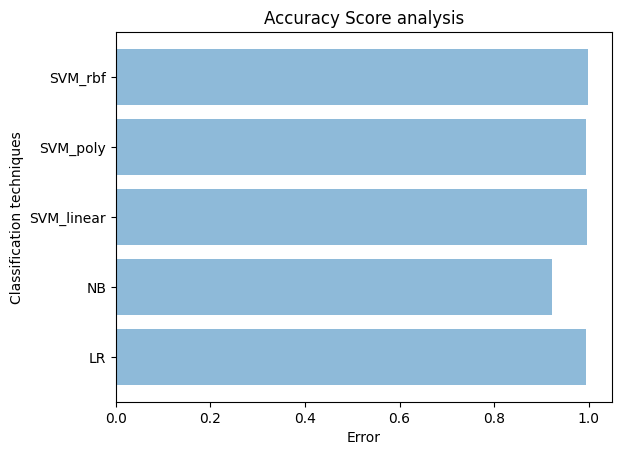

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
objects = ('LR', 'NB', 'SVM_linear', 'SVM_poly', 'SVM_rbf')   # plotting rmse of all the regression techniques
y_pos = np.arange(len(objects))
performance = [accuracy_lr1, accuracy_nb1, accuracy_svm, accuracy_svm2, accuracy_svm3]  # rmse performance

# printing the bar chart showing RMSE of all the 4 regression techniques mentioned above
print(performance)
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Error')
plt.ylabel('Classification techniques')
plt.title('Accuracy Score analysis')

plt.show()